# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [25]:
from importlib import reload
reload(analyseData)
reload(prepData)

<module 'util.preprocess_Data' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\preprocess_Data.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData

In [2]:
# parse & handle data
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# clustering
import hdbscan
import nodevectors

# similarity metrics for keyword embedding of nodes
from sklearn.metrics.pairwise import cosine_similarity

# dimensionaliy reduction
import nodevectors
import umap
import umap.plot
from sklearn.decomposition import PCA

# evaluation
from sklearn.metrics import ConfusionMatrixDisplay

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [4]:
# read node information
node_info = (pd.read_csv('data/node_information.csv', index_col = 0, header = None)
                 .rename_axis("node"))
node_info.shape

(3597, 932)

In [5]:
# read edge lists (train and test)
train = pd.read_csv('data/train.txt', header = None, sep = " ").rename(columns = {0: "node1", 1: "node2", 2: "y"})
test  = pd.read_csv('data/test.txt' , header = None, sep = " ").rename(columns = {0: "node1", 1: "node2"})

# sort edge lists (so lower numbered node is always in first column)
train = train[["node1", "node2"]].apply(lambda x: np.sort(x), axis = 1, raw = True).assign(y = train.y)
test  = test[[ "node1", "node2"]].apply(lambda x: np.sort(x), axis = 1, raw = True)

### 3. Missing values, duplicates and find possible data leakage

#### 3.1 Edge lists

There are no duplicates in the dataset! Also no edges that are present in both train and test!

In [6]:
# number of duplicates in train
print(train.shape)
train.duplicated(subset = ["node1", "node2"]).value_counts()

(10496, 3)


False    10496
dtype: int64

In [7]:
# number of duplicates in test
print(test.shape)
test.duplicated().value_counts()

(3498, 2)


False    3498
dtype: int64

In [8]:
# number of edges present in both datasets
all_data = pd.concat([train[["node1", "node2"]], test])
print(all_data.shape)
all_data.duplicated().value_counts()

(13994, 2)


False    13994
dtype: int64

Are there any predictions where both nodes are the same? (if so, prediction should always be 1)

In [9]:
# how many edges have the same source and target node?
print(train.loc[train["node1"] == train["node2"]].shape)
print(test.loc[test["node1"] == test["node2"]].shape)

# remove those edges from the data (we will just predict 1 for them)
train = prepData.clean_edgelist(train)
test  = prepData.clean_edgelist(test)

(31, 3)
(17, 2)


create our graph based on the training data
- without edges where source and target are the same (doesn't make sense)
- without not actual edges (where y is 0)

In [10]:
# create graph
G = prepData.fetch_graph(train)

# validate (same number of edges?)
print(train.loc[((train.node1 != train.node2) & (train.y == 1))].shape)
print(G.number_of_edges())

# check if graph is connected -- if not, return greatest connected component subgraph
gcc = prepData.get_gcc(G)

(5217, 3)
5217
The graph is connected


#### 3.2 Node Information

In [11]:
node_info.isnull().sum().sum()

0

no missing values

In [12]:
# number of duplicates
print(node_info.shape)
node_info_tf = node_info.assign(duplicate = lambda df_: df_.duplicated())
node_info_tf.duplicate.value_counts()

(3597, 932)


False    2972
True      625
Name: duplicate, dtype: int64

625 nodes have exactly the same embedding! But do they also have the same set of neighbours?

In [13]:
# get neighbors of each node
node_info_tf = (node_info_tf
    .assign(neighbors = lambda df_: [tuple(set([i for i in nx.all_neighbors(G, node)])) for node in df_.index]))

In [14]:
# number of duplicates
print(node_info_tf.shape)
node_info_tf = node_info_tf.assign(duplicate = lambda df_: df_.duplicated())
node_info_tf.duplicate.value_counts()

(3597, 934)


False    3585
True       12
Name: duplicate, dtype: int64

12 nodes have the same embedding as well as the same set of neighbors!

In [15]:
node_info_tf.loc[node_info_tf.duplicate]

,1,2,3,4,5,6,7,8,9,10,...,925,926,927,928,929,930,931,932,duplicate,neighbors
node,,,,,,,,,,,,,,,,,,,,,
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,"(3809,)"
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
3319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
3492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,"(3809,)"


### 4. Graph Analysis

In [16]:
# get basic stats of network
prop = analyseData.compute_network_characteristics(graph = G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))
print("Avg. clustering coefficient: {}".format(prop['avg_clustering']))
print("Avg. shortest path: {}".format(prop['avg_shortest_path']))

Number of nodes: 3597
Number of edges: 5217
Min. degree: 1
Max. degree: 361
Mean degree: 2.9007506255212676
Median degree: 2.0
Density: 0.000806660351924713
Avg. clustering coefficient: 0.019560058406301813
Avg. shortest path: 6.038627233236943


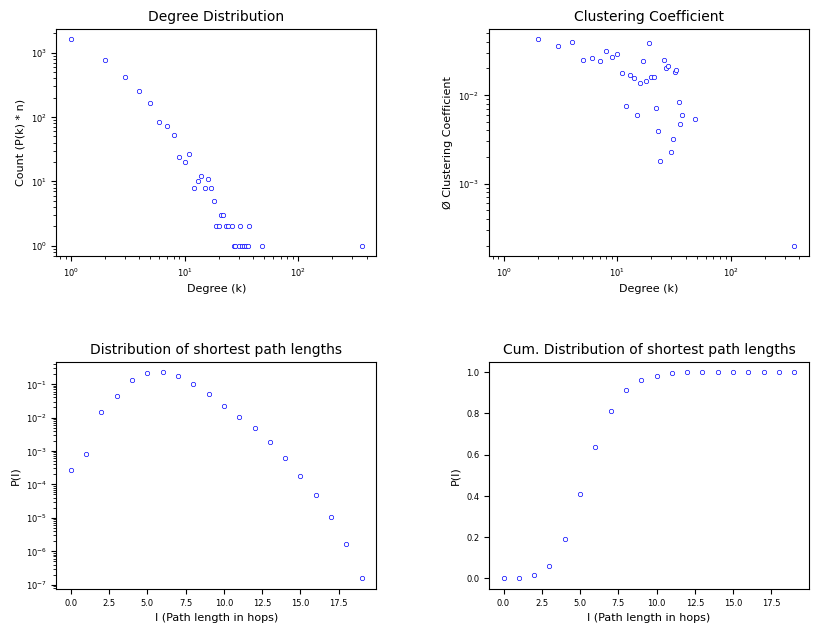

In [17]:
analyseData.plot_graph_stats(G)

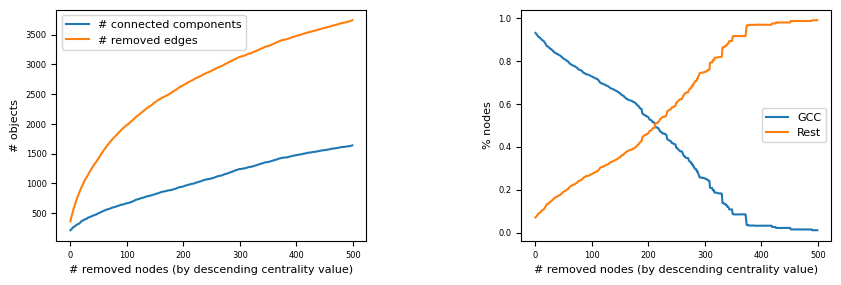

In [18]:
# choose a centrality measure
node2values = nx.degree_centrality(G)
k = 500 # k is the number of nodes to be removed
analyseData.plot_robustness_analysis(G, node2values, k)

### 5. Graph-based features

To understand the usefulness of potential graph-based features, we need to perform a train-validation split and validate the feature importance on the validation set.

In [19]:
# generate train and validation data (postive edges)
G_train, train_pos_edges, val_pos_edges = prepData.train_val_split_pos_edges(G, testing_ratio = 0.1)

# validate that graph is still connected
gcc = prepData.get_gcc(G_train)

Number of positive edges for training: 4696
Number of positive edges for validation: 521
Number of edges in original graph: 5217
Number of edges in training graph: 4696
The graph is connected


In [20]:
# generate train and validation data (negative edges)
train_neg_edges, val_neg_edges = prepData.train_val_split_neg_edges(train, testing_ratio = 0.1)

# validate
print(train_neg_edges.shape)
print(val_neg_edges.shape)

(4723, 3)
(525, 3)


In [21]:
# append to dataframe
train_tf = pd.concat([train_pos_edges, train_neg_edges])
val_tf = pd.concat([val_pos_edges, val_neg_edges])

# validate
print(train.shape)
print(train_tf.shape)
print(val_tf.shape)

(10465, 3)
(9419, 3)
(1046, 3)


Let us now enrich our dataset with potential features.

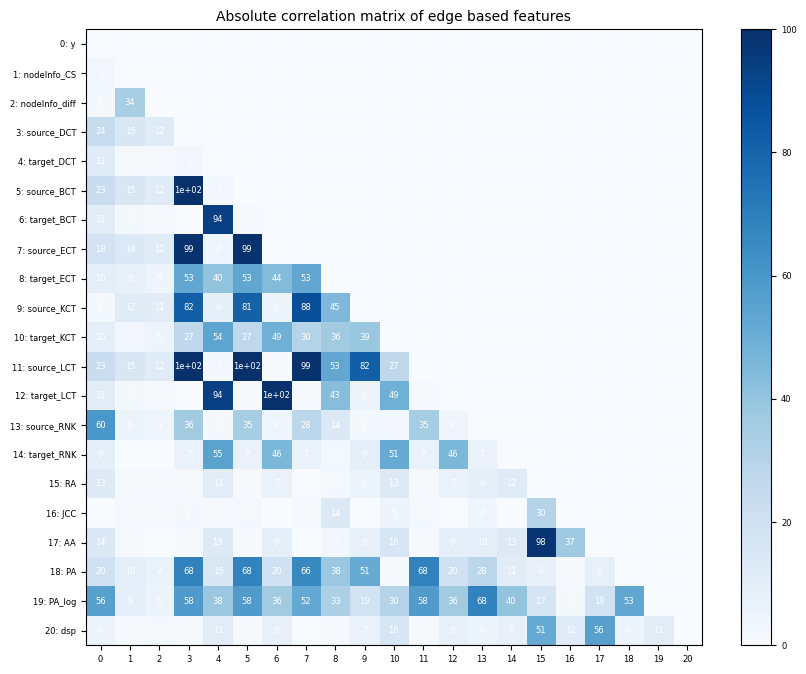

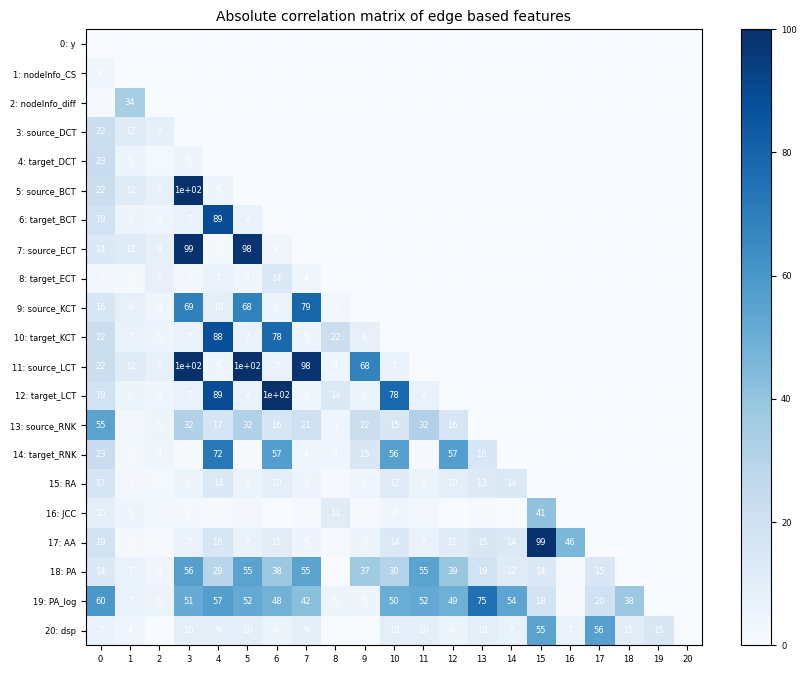

In [26]:
# enrich train and validation data
train_tf = prepData.enrich_edgelist(train_tf, G_train, node_info)
val_tf   = prepData.enrich_edgelist(val_tf, G_train, node_info)

# plot correlation with target
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

In [27]:
X_train, y_train = prepData.split_frame(train_tf)
X_val, y_val     = prepData.split_frame(val_tf)

In [28]:
# models
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [48]:
# basic XGBoost (best to use for RFECV as very short runtime)
clf = XGBClassifier(n_estimators = 100, max_depth = 5, eta = 0.05)
clf.fit(X_train, y_train)

# predict train
y_train_hat = clf.predict(X_train)
# compute R^2 metric
acc_train = accuracy_score(y_train, y_train_hat)

# predict val
y_val_hat = clf.predict(X_val)
# compute R^2 metric
acc_val = accuracy_score(y_val, y_val_hat)

# print performance
print(f"Acc train: {acc_train}")
print(f"Acc val : {acc_val}")

Acc train: 0.8944686272428071
Acc val : 0.7619502868068834


### 6. Node embedding features

Let us see if we can create a meaningful clustering based on the embeddings of each node. This is based on the intuition that nodes that share many keywords should likely belong to the same cluster (e.g. Wikipedia sports vs math pages).

However, the embedding of each node is of very high dimension. Let us first try to reduce the dimensionality before clustering the data. First, I thought about using PCA -- however, for this problem it is probably a very bad idea. Why? PCA finds the global structure (only linear!) but local neighborhoods are not preserved (far away points can become nearest neighbors in projected subspace). But all that I am interested in, is to find the local neighborhoods. So if I run PCA I would reduce the dimension but lose this information. In consequence, I will use UMAP.

In [28]:
# create umap embedding of nodes
reducer = umap.UMAP(metric = "cosine",
                    n_neighbors=15,
                    min_dist=0,
                    n_components=2).fit(node_info)

embedding = reducer.transform(node_info)

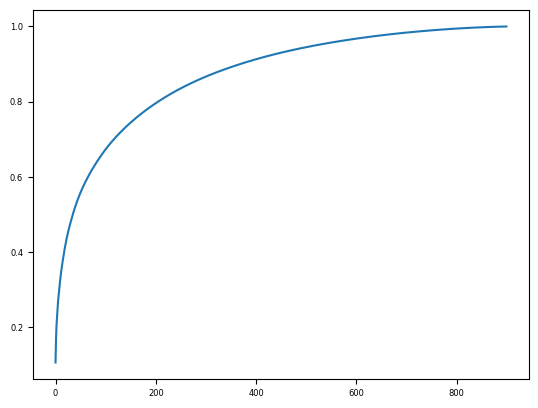

In [24]:
# create PCA embedding
n_components = []
explained_variance = []

pca = PCA(n_components = 900)
pca.fit(node_info)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
plt.plot(explained_variance)

First 10 features explain 30% of variance. Let us keep those and put it through HDBSCAN.

In [34]:
embedding = PCA(n_components = 10).fit_transform(node_info)

Text(0.5, 1.0, 'UMAP projection (first 2 dim) of Node information')

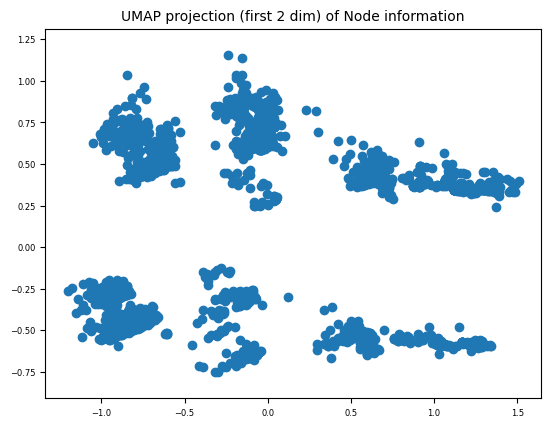

In [35]:
# plot umap embedding of nodes
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection (first 2 dim) of Node information')

In [36]:
# use umap embedding to cluster nodes
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size = 300)
clusterer.fit(embedding)

clustered = (clusterer.labels_ >= 0)
print(f"Share of clustered nodes: {np.sum(clustered) / node_info.shape[0]}")

Share of clustered nodes: 0.8793438976925215


In [37]:
# look at clusters
np.unique(clusterer.labels_, return_counts = True)

(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([434, 955, 789, 446, 333, 640], dtype=int64))

<AxesSubplot: ylabel='$\\lambda$ value'>

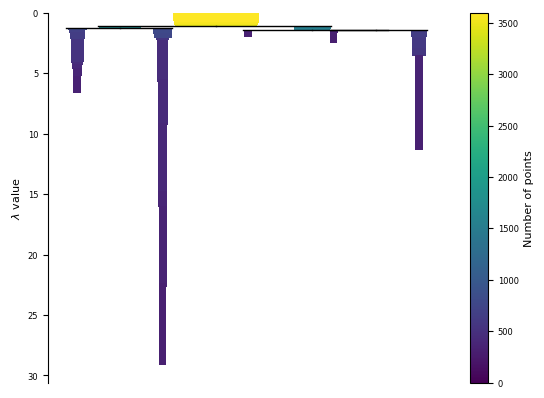

In [38]:
# visualize clusters of HDBSCAN
clusterer.condensed_tree_.plot()

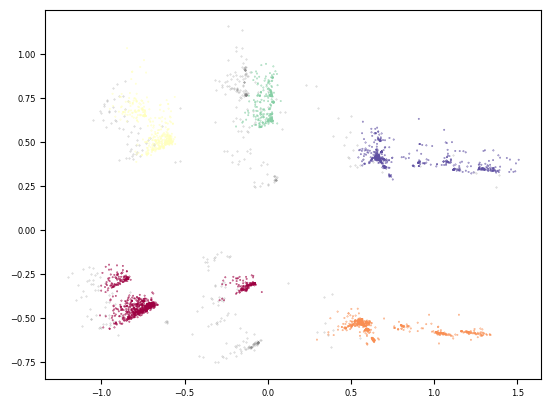

In [39]:
# plot clustered nodes based on their embedding
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=clusterer.labels_[clustered],
            s=0.1,
            cmap='Spectral')

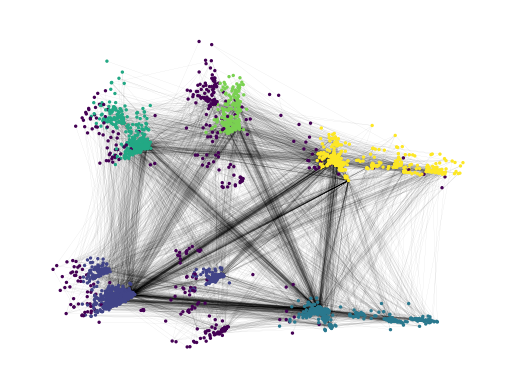

In [40]:
# use embedding and cluster of each node to visualize graph
data = dict()
for i, node in enumerate(node_info.index):
    data[node] = {"emb_1": embedding[i][0], "emb_2": embedding[i][1], "cluster": clusterer.labels_[i]}

nodes = G.nodes()
pos = {node: [data[node]["emb_1"], data[node]["emb_2"]] for node in nodes}
labels = [data[node]["cluster"] for node in nodes]

nx.draw_networkx_edges(G, pos, alpha=0.2, width = 0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=2, node_color=labels)
plt.axis('off')

plt.show()

In [41]:
# compute connectedness between groups
node_stats = (pd.DataFrame.from_dict(data, orient = "index")
    .assign(degree = lambda df_: [G.degree(node) for node in df_.index])
    .assign(neighbors = lambda df_: [[df_.loc[node].cluster for node in G.neighbors(node)] for node in df_.index])
    .assign(neighbors = lambda df_: [[lst.count(i) for i in np.unique(labels)] for lst in df_.neighbors])
)

node_stats = (pd.concat([node_stats, node_stats.neighbors.apply(pd.Series).divide(node_stats.degree, axis=0).round(2)], axis=1)
    .rename(columns = {idx: cluster for idx, cluster in zip(range(len(np.unique(labels))), np.unique(labels))})
)

agg_dict = {col: "mean" for col in list(np.unique(labels))}
agg_dict["degree"] = "sum"
agg_dict["cluster"] = "count"
(node_stats
    .groupby("cluster").agg(agg_dict).rename(columns = {"cluster" : "nbr_nodes"}).round(2)
    .assign(avg_degree = lambda df_: (df_.degree / df_.nbr_nodes).round(2))
)

,-1,0,1,2,3,4,degree,nbr_nodes,avg_degree
cluster,,,,,,,,,
-1,0.12,0.27,0.20,0.12,0.08,0.21,1235,434,2.85
0,0.11,0.25,0.20,0.10,0.08,0.26,2632,955,2.76
1,0.12,0.24,0.21,0.11,0.08,0.25,2238,789,2.84
2,0.12,0.23,0.19,0.14,0.06,0.26,1158,446,2.60
3,0.10,0.20,0.24,0.10,0.08,0.28,870,333,2.61
4,0.11,0.24,0.22,0.11,0.07,0.26,2301,640,3.60
